In [473]:
import numpy as np
import scipy
from scipy.integrate import quad
import scipy.constants as phys
import os
import matplotlib.pyplot as plt
import time

In [474]:
##############################################################################################
# Bernouli function approximation for calculating current                                    #
##############################################################################################
def Ber(X):
    res = np.zeros(len(X))
    mask1 = X<=2
    mask2 = (-2<X) & (X<1.29)
    mask3 = X>=1.29
    res[mask1] = -X[mask1]
    res[mask2] = 1-0.5*X[mask2]
    res[mask3] = X[mask3]*np.exp(-X[mask3])
    
    return res

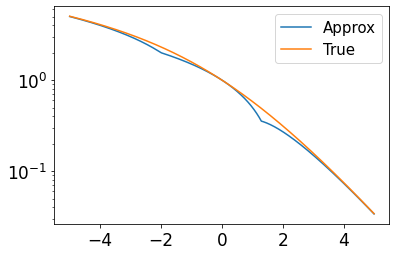

Bernouli fcn calc time : 0.0009996891021728516


In [475]:
norm_V = np.arange(-5,5,0.01)

plt.plot(norm_V, Ber(norm_V), label = "Approx")
start = time.time()
plt.plot(norm_V, norm_V/(np.exp(norm_V)-1), label = "True") #....? 이게 더빠르네..?
fin = time.time()
plt.yscale('log')
plt.legend()
plt.show()
print("Bernouli fcn calc time :", fin-start)

Occupation intg calc time : 0.002000570297241211
Enhancement calc time : 0.0010004043579101562


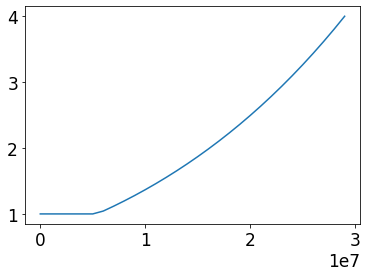

In [476]:
EF_ITO, EF_LiFAl   = -5.0, -3.3                                      # Each Fermi level
HOMO_NPD, LUMO_NPD, HOMO_Alq3, LUMO_Alq3 = -5.4, -2.4, -5.62, -2.85  # Each HOMO/LUMO level
SigH_NPD, SigL_NPD, SigH_Alq3, SigL_Alq3 = 0.1, 0.11, 0.15, 0.15     # Magnitude of disorders inlayers, [eV]. not [J]!!!! 
V_H = 10                                  # High voltage
kbT = 0.0258
q  = 1.6022e-19
e0 = 8.8542e-12
er = 3.5
a  = 1.e-9                                   # Mean distance of intermolecular cite
ly, dx = 200, 1.e-9                          # total grid length and dx
dtV  = dx**2/4                               # dt for V calculation, 2.5e-19
dtP  = 1.e-16                                # dt for p calculation ~ 400*dtV
QdivE = q/e0/er
f_const = q/(4*np.pi*e0*er*kbT**2)          # Constant for field normalization. kbT holds [eV].
Max_iter = int(1.e4)
MAX_INT, MIN_INT = 13,-7                     # Max and min value of fermi integral


##############################################################################################
# Integrating Occupation probability to account field-dependent injection in the             #
# interface of both electrodes. We hold negative notations for energy level representations. #
##############################################################################################
def occ_function(E, EF, E0, Sig, field, arg, MAX = MAX_INT, MIN = MIN_INT):
    e_0, field = 0, field
    if field<=0:
        field = 1
        
    if arg == "Hole":
        e_0 = E0 + np.sqrt(f_const*field)*kbT
        return 1/(1+np.exp(-(E-EF)/kbT))*np.exp(-(E-e_0)**2/(2*Sig**2))
    else:
        e_0 = E0 - np.sqrt(f_const*field)*kbT
        return 1/(1+np.exp((E-EF)/kbT))*np.exp(-(E-e_0)**2/(2*Sig**2))

def prob_intg(EF, E0, Sig, field, *args, MAX = MAX_INT, MIN = MIN_INT):
    arg = args[0]
    if args[0] == "Hole":
        result = 1/np.sqrt(2*np.pi*Sig**2)*quad(occ_function, MIN, MAX, args=(EF, E0, Sig, field, arg))[0]
        #print("hole conc prob :", result, " Density :", result/a**3)
        return result
        
    elif args[0] == "Elec":
        result = 1/np.sqrt(2*np.pi*Sig**2)*quad(occ_function, MIN, MAX, args=(EF, E0, Sig, field, arg))[0]
        #print("electron conc prob :", result, " Density :", result/a**3)
        return result
    else:
        pass
##############################################################################################
# The field enhancement factor in thermionic injection.                                      #
##############################################################################################
def beta(field, *args):
    f = f_const*field
    if f<3.3317:                 # Since return fcn is concave, we select a threshold..
        return 1
    else:
        psi = 1/f+1/np.sqrt(f)-1/f*np.sqrt(1+2*np.sqrt(f))
        return (4*psi**2)*np.exp(np.sqrt(f))
    
start = time.time()
p0_NPD = prob_intg(EF_ITO, HOMO_NPD, SigH_NPD, 0, "Hole") # Test for Anode interface()
n0_NPD = prob_intg(EF_LiFAl, LUMO_NPD, SigL_NPD, 0, "Elec") # Test for cathode interface(Alq3-LiF/Al)
#p0_LiFAl = 1/n0_LiFAl/a**3;print("hole conc density :", p0_LiFAl)
# Assume that minority carrier conc. in both electorde edges is not bounded.

# AHA! calculation cost 비싸니까 iteration 10번 돌때마다 injection profile을 바꾸자!

fin = time.time()
print("Occupation intg calc time :", fin-start)

start = time.time()
field_test = np.arange(0, 3.e7, 1.e6)
field_res  = [beta(i) for i in field_test]
fin = time.time()
plt.plot(field_test, field_res)
print("Enhancement calc time :", fin-start)

In [477]:
print(p0_NPD, n0_NPD)

0.00018432929468275251 8.851564566497535e-12


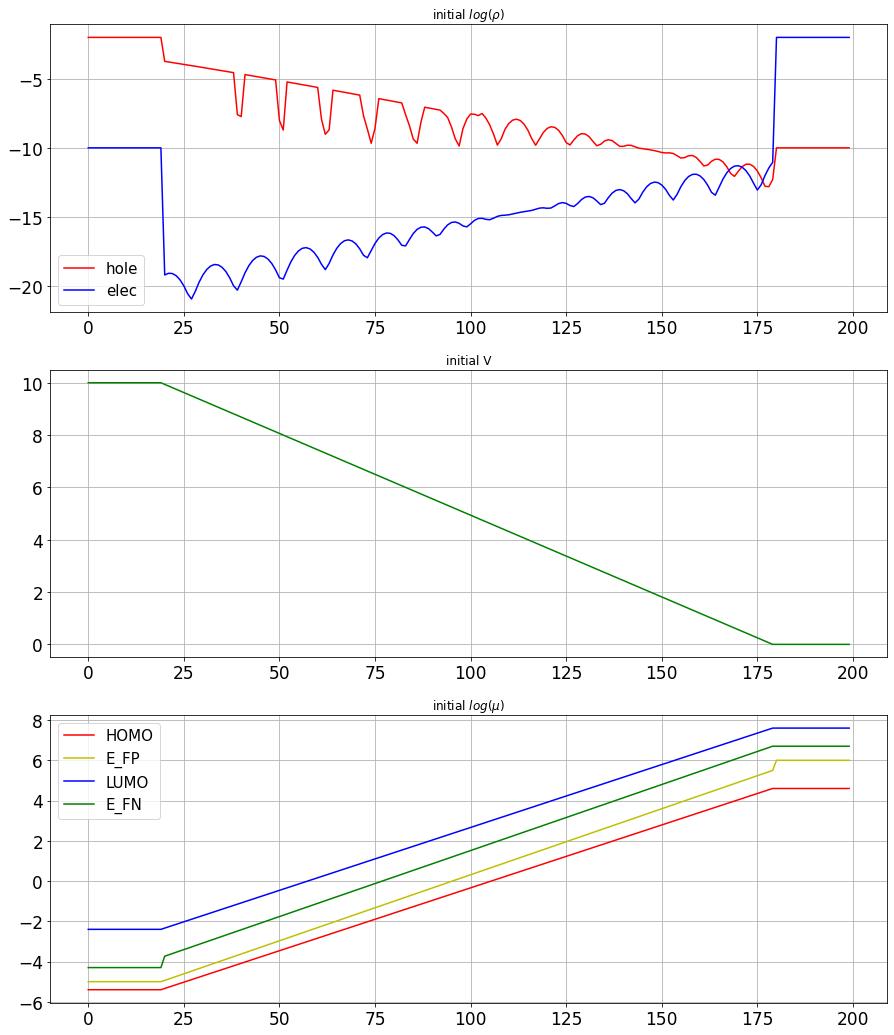

In [478]:
##############################################################################################
# Initialization process : mn0/mp0 : mobility // p,n = occupation probability.               #
# Be aware that the given n and p are not a charge density(/m^3).                            #
# Input : Voltage                                                                            #
# Output : V, p, n, mp0, mn0, pt, nt, SigHat_p, SigHat_n. Sig == disorder.                   #
#          anode, cathode, HTL, ETL : Boolean array masks to divide layers. In this          #
#          simulation, 'ETL' is unused as we only account a single HTL.                      #
##############################################################################################
def world_init(V_H):
    ly, dx = 200, 1.e-9
    anode, cathode, HTL,ETL = np.zeros((4, ly), dtype = bool)
    anode[:20], HTL[20:180], cathode[180:] = True, True, True

    #Initialization
    #mp0 == Zero-field, zero-concentration mobility
    V, p, n, mp0, mn0, pt, nt, E_FP, E_FN, SigHat_p, SigHat_n = np.zeros((11,ly), dtype = np.float64) 
    # V, p/n density, mu0(T)_p/n, \rho(trap)_p/n, Normalized disorder. Electrodes are initialized as 2
    V_H = V_H
    V[anode], V[cathode] = V_H,0.
    # Electrode disorder 초기화. 
    SigHat_p[anode], SigHat_p[cathode], SigHat_n[anode], SigHat_n[cathode] = 2,2,2,2
    # 나머지 부분 disorder 초기화.
    SigHat_p[HTL], SigHat_n[HTL] = SigH_NPD/kbT, SigL_NPD/kbT
    
    # Initialize V
    delta = np.zeros(ly, dtype = np.float64) 
    for i in range(20,180,1):
        V[i] = V[0]*(179/160 - 1/160*i)
        delta[i] = 1/160*(i-20)/2
    
    # Initialize \mu_0(T)
    mp0[anode], mp0[HTL], mp0[cathode]= 1.e-6, 3.5e-8, 1.e-7
    mn0[anode], mn0[HTL], mn0[cathode]= 1.e-5, 3.5e-8, 1.e-5
    
    # Initialize E_FP, E_FN
    E_FP[anode], E_FP[HTL], E_FP[cathode] = EF_ITO, EF_ITO+(V_H+delta[HTL]-V[HTL]), EF_ITO+V_H+1
    E_FN[anode], E_FN[HTL], E_FN[cathode] = EF_LiFAl-1, EF_LiFAl+(V_H-delta[::-1][HTL]-V[HTL]), EF_LiFAl+V_H # +1 to prevent overflow
    # Initialize both E levels
    H_NPD = HOMO_NPD + V_H-V
    L_NPD = LUMO_NPD + V_H-V

    p[anode], p[cathode] = 1.e-2, 1.e-10
    n[anode], n[cathode] = 1.e-10, 1.e-2    # n0p0(ITO) = 1.e26, n0p0(LiF/Al) = 1.e28
    for i in range(20,180,1):
        p[i] = prob_intg(E_FP[i], H_NPD[i], SigH_NPD, 0, "Hole")
        n[i] = prob_intg(E_FN[i], L_NPD[i], SigL_NPD, 0, "Elec")

    fig, ax = plt.subplots(3,1,figsize = (15,18))
    X_ = np.arange(0,200,1)
    ax[0].plot(X_, np.log10(p), c = 'r', label = "hole")
    ax[0].plot(X_, np.log10(n), c = 'b', label = "elec")
    ax[0].set_title("initial "+r"$log(\rho)$")
    ax[0].legend()
    ax[1].plot(X_, V, c = 'g')
    ax[1].set_title("initial V")
    ax[2].plot(X_, H_NPD, c = 'r', label="HOMO")
    ax[2].plot(X_, E_FP, c = 'y', label="E_FP")
    ax[2].plot(X_, L_NPD, c = 'b', label="LUMO")
    ax[2].plot(X_, E_FN, c = 'g', label="E_FN")
    ax[2].set_title("initial "+r"$log(\mu)$")
    ax[2].legend()
    for axes_ in ax:
        axes_.grid()
    
    return V, p, n, mp0, mn0, pt, nt, H_NPD, L_NPD, E_FP, E_FN, SigHat_p, SigHat_n, anode, cathode, HTL, ETL

V, p, n, mp0, mn0, pt, nt, H_NPD, L_NPD, E_FP, E_FN, SigHat_p, SigHat_n, anode, cathode, HTL, ETL = world_init(V_H)

In [479]:
def delta(sig_p, sig_n, *args):
    if args[0] == "hole":
        return 2*(np.log(sig_p**2-sig_p) - 0.32663426)/sig_p**2
    elif args[0] == "elec":
        return 2*(np.log(sig_n**2-sig_n) - 0.32663426)/sig_n**2
    else:
        return "Error : Invalid Argument."
    
def g(hole, electron, sig_p, sig_n, *args):                  # 전극은 2로 초기화 // log(sigparam)-log(log(4)) >=0이 되게. 
    if args[0] == "hole":
        sigparam = sig_p**2-sig_p
        #print(sigparam)
        delta = 2*(np.log(sigparam) - 0.32663426)/sig_p**2
        return np.exp(0.5*sigparam*(2*hole)**delta)          # probability만 취급하니 a**3은 뗀다. 
    elif args[0] == "elec":
        sigparam = sig_n**2-sig_n
        delta = 2*(np.log(sigparam) - 0.32663426)/sig_n**2
        return np.exp(0.5*sigparam*(2*electron)**delta)
    else:
        return "Error : Invalid Argument."
# Fea/sig = dV / (sig(ev)) = dV/sigHat*kbT
def f(sig_p, sig_n, dV, *args):
    if args[0] == "hole":
        dV[dV>2*sig_p]= 2*sig_p[dV>2*sig_p]
        sigparam_1 = 0.44*(sig_p**1.5 - 2.2)
        sigparam_2 = np.sqrt(1+0.8*(dV/sig_p)**2)-1          # sig = disorder in eV.
        exponent   = sigparam_1*sigparam_2
        return np.exp(exponent)
    elif args[0] == "elec":
        dV[dV>2*sig_n]= 2*sig_n[dV>2*sig_n]
        sigparam_1 = 0.44*(sig_n**1.5 - 2.2)
        sigparam_2 = np.sqrt(1+0.8*(dV/sig_n)**2)-1          
        exponent   = sigparam_1*sigparam_2
        return np.exp(exponent)
    else:
        return "Error : Invalid Argument."

g_factor = g(p, n, SigHat_p, SigHat_n, "elec")
#print("Enhancement factor by concentration \n", g_factor)
dV_test = np.zeros_like(V)
dV_test[:-1] = V[1:]-V[:-1]
f_factor = f(SigHat_p, SigHat_n, dV_test, "elec")
#print("Enhancement factor by field \n", f_factor)
print("The total enhancement factor : \n", g_factor*f_factor)

The total enhancement factor : 
 [1.01683571 1.01683571 1.01683571 1.01683571 1.01683571 1.01683571
 1.01683571 1.01683571 1.01683571 1.01683571 1.01683571 1.01683571
 1.01683571 1.01683571 1.01683571 1.01683571 1.01683571 1.01683571
 1.01683571 1.01694553 1.00036073 1.00036892 1.00036765 1.00035722
 1.00034002 1.00031961 1.00029988 1.00028985 1.00030534 1.00033162
 1.00036132 1.00038984 1.00041182 1.0004225  1.00041941 1.00040327
 1.00037774 1.00034808 1.00031996 1.00030812 1.00033272 1.00037119
 1.00041403 1.00045452 1.00048491 1.00049857 1.00049232 1.00046762
 1.00043005 1.0003873  1.00034844 1.00034288 1.0003858  1.00044345
 1.0005042  1.00055773 1.00059321 1.00060265 1.00058382 1.00054113
 1.00048394 1.00042419 1.00038878 1.00043067 1.00050832 1.00059273
 1.00066901 1.00072194 1.00073971 1.00071816 1.00066234 1.0005848
 1.00050472 1.00047979 1.00055997 1.00067155 1.00078024 1.00086453
 1.00090618 1.00089551 1.00083509 1.0007394  1.0006393  1.00062961
 1.00074756 1.00089072 1.00101

In [480]:
prob_intg(EF_LiFAl, LUMO_NPD, SigL_NPD, 9.e6, "Elec")*beta(9.e6)

5.489585957135928e-11

In [481]:
# Constants for Trapping Calculation# 
A_t     = 4*np.pi*(f_const*kbT)**2
E_trap  = H_NPD+0.5
Sig_trap= 0.1
N_t     = 3.e22
p_t      = prob_intg(EF_ITO, E_trap[0], Sig_trap, 1., "Hole")*N_t*a**3
A_t
#n1      = prob_intg(E_trap, LUMO_NPD, SigL_NPD, 1.e6, "Elec") # -> n1 무시. 

3.1955780900333472e-15

In [482]:
V_H_list = [0.1, 0.3, 0.5, 1]
V_fin    = {}                                    # final field 
p_fin    = {}
n_fin    = {}
jp_fin   = {}                                    # final p current
jn_fin   = {}               
for V_H in V_H_list:
    print(int(1.5e4*(1+V_H**1.5)**0.5))

15235
16185
17451
21213


iterations : 15235
0.1 , 580.116631269455 sec
iterations : 16185
0.3 , 624.2823941707611 sec
iterations : 17451
0.5 , 679.4413189888 sec
iterations : 21213
1 , 840.1658844947815 sec


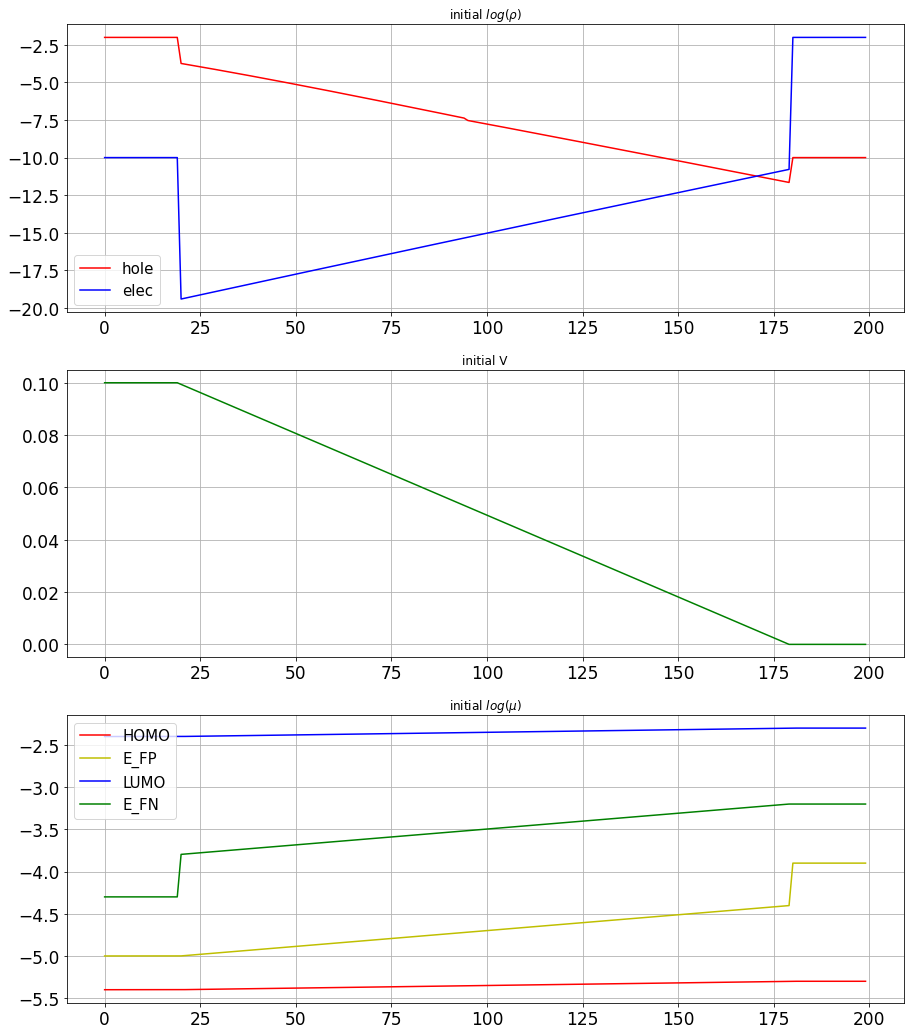

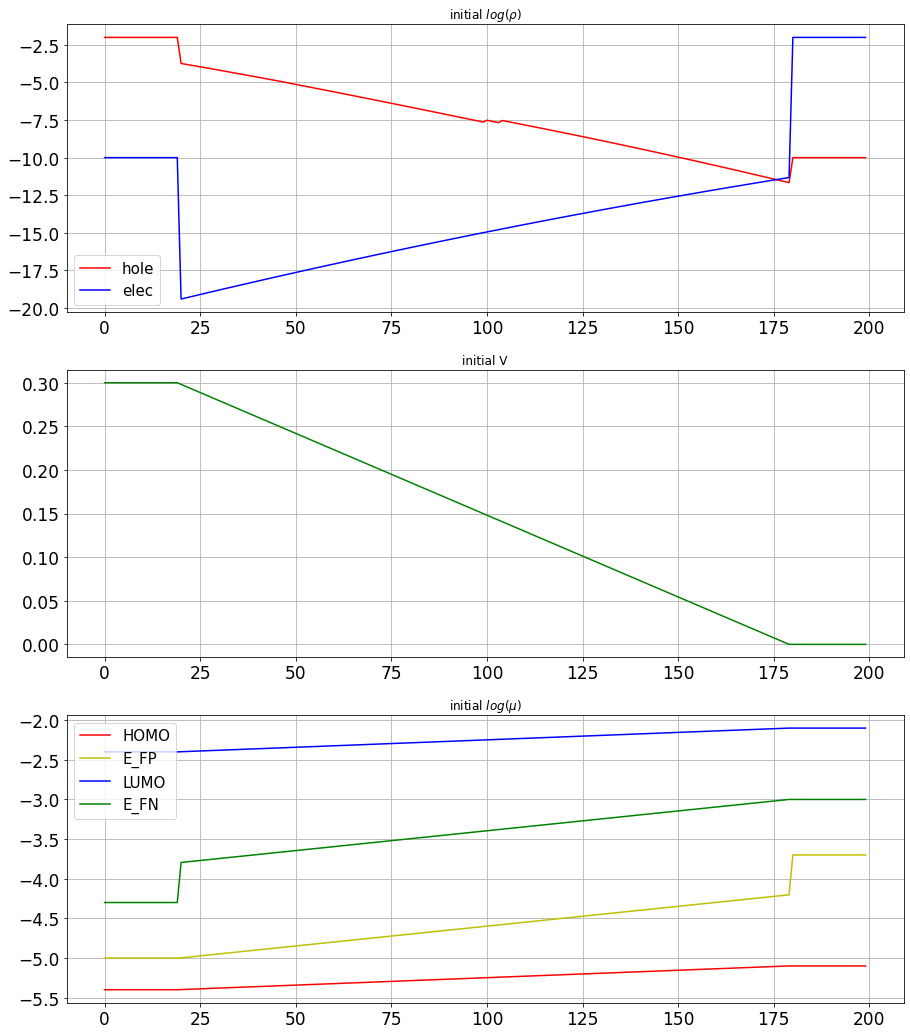

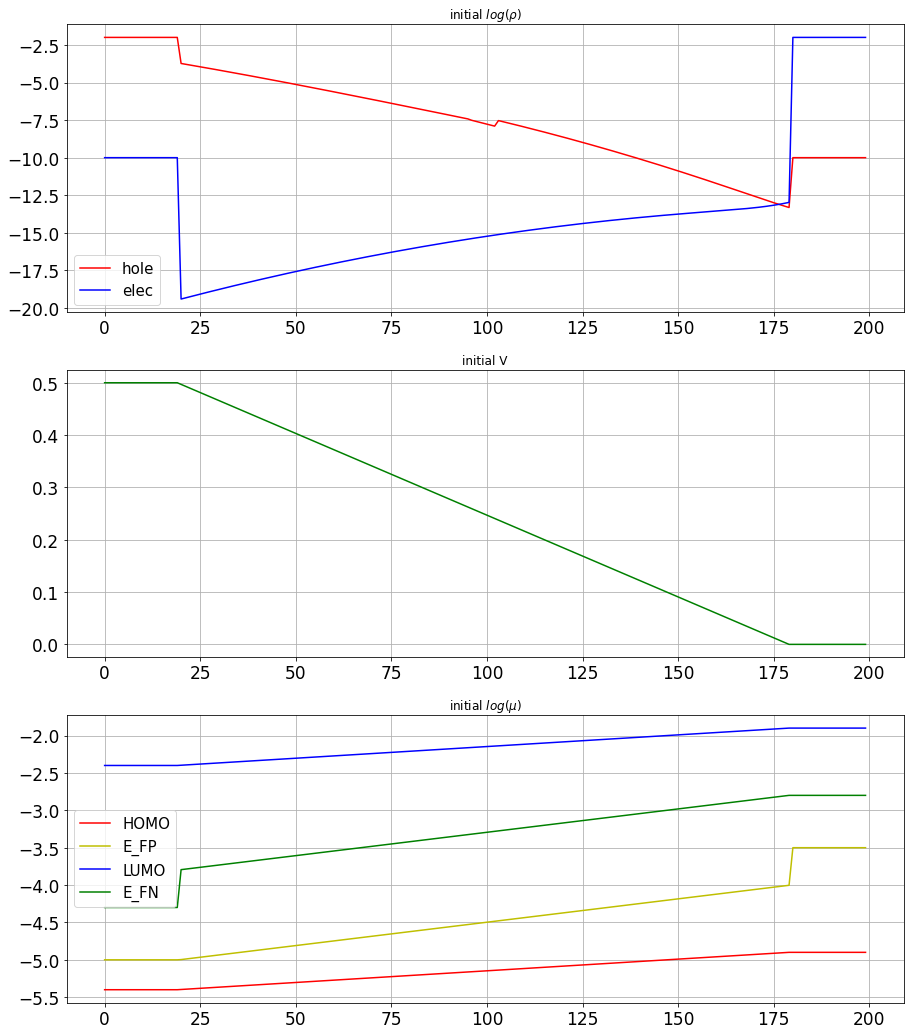

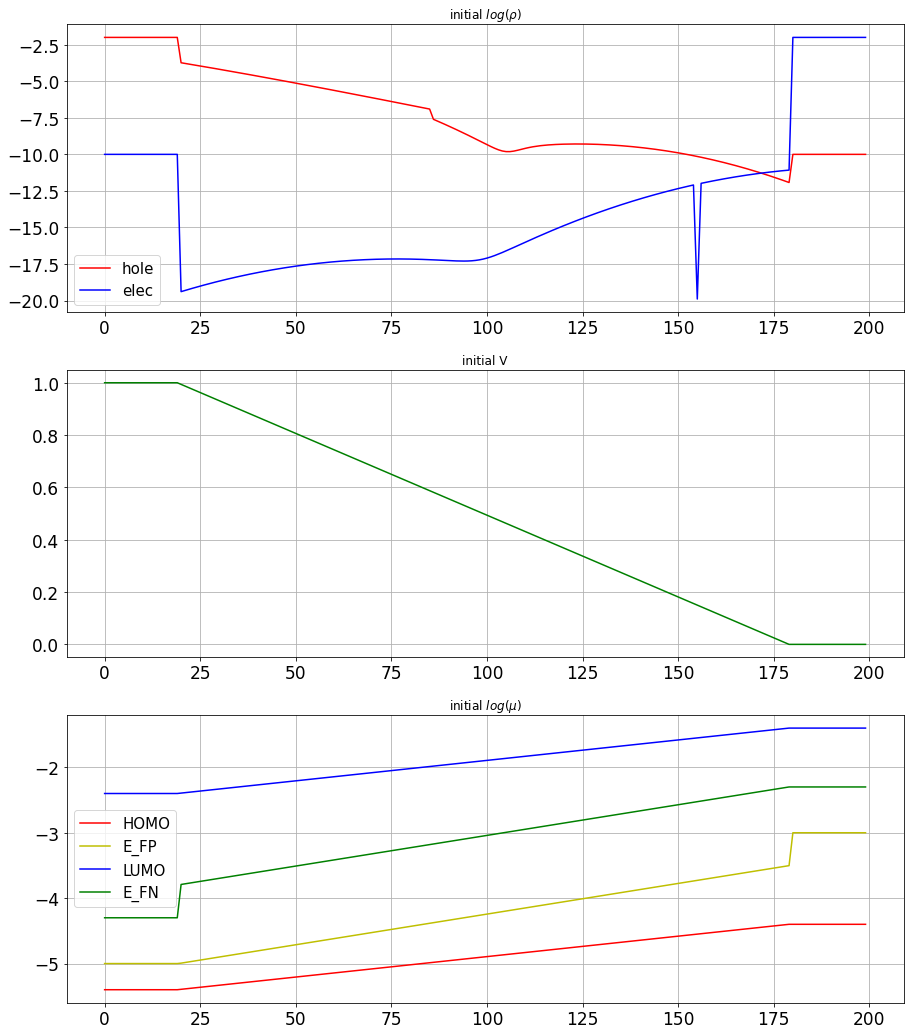

In [483]:
##############################################################################################
# Calculation part. please read the references in each step below.                           #
# Here we have two calculation boundaries (bound) to guarantee numerical stability.          #
##############################################################################################
for V_H in V_H_list:
    # 0. Initialization.
    V, p, n, mp0, mn0, pt, nt, \
    H_NPD, L_NPD, E_FP, E_FN, SigHat_p, SigHat_n, \
    anode, cathode, HTL, ETL = world_init(V_H)
    
    bound = [0,int(1000*V_H**1.2), int(1000*V_H**1.5)]
    start = time.time()
    rp_star    = kbT/dx**2*mp0              # Initial hopping rate.
    rn_star    = kbT/dx**2*mn0
    n0_anode_bound   = np.exp(-(LUMO_NPD - EF_ITO - SigL_NPD**2/2/kbT)/kbT)
    p0_cathode_bound = np.exp(-(EF_LiFAl - HOMO_Alq3 - SigH_Alq3**2/2/kbT)/kbT)
    threshold        = int(np.sqrt(1+V_H))*2000  # For smooth transition. After this iteration, n and p will be updated.
    
    # Trap p
    p_trap = np.zeros(ly, dtype = np.float64)
    # Integration regime
    #MAX_INT, MIN_INT = V_H/2+5
    
    Max_iter = int(1.5e4*(1+V_H**1.5)**0.5)
    print("iterations :", Max_iter)
    for k in range(Max_iter):

        # 1. First, determine V with SOR method : O(N^1.5).
        post_V = np.zeros(ly, dtype = np.float64)

        for i in range(ly):
            if (i==0)|(i==199): post_V[i] = V[i]
            else:               post_V[i] = 0.5*(QdivE*(p[i]+p_trap[i]-n[i])*(dx**2/a**3) + V[i+1] + post_V[i-1]) # Occ prob로 들어가니 

        V = post_V
        V[cathode], V[anode] = 0,V_H

        # 2. Calculate field strength, and the hopping rate. 
        field = np.zeros(ly, dtype = np.float64)
        #field[:-1] = -1*(V[1:] - V[:-1])/dx                 # F_i = -(V_i+1  -  V_i)/dx
        field = -1*np.gradient(V, dx)
        #Q) np.gradient로 대체하고 n_minus_i가 field_i에 dependent하게 만들면?

        g_factor_p = g(p, n, SigHat_p, SigHat_n, "hole")     # 여기 4개는 parallization 시켜도 괜찮을듯. 
        g_factor_n = g(p, n, SigHat_p, SigHat_n, "elec")
        f_factor_p = f(SigHat_p, SigHat_n, field*dx, "hole") # dV, 부호 상관없음. 
        f_factor_n = f(SigHat_p, SigHat_n, field*dx, "elec") 

        rp_param = rp_star*g_factor_p#*f_factor_p
        rp_plus  = rp_param*np.exp(field*dx/2/kbT)               # i -> i+1, hole
        rp_minus = np.zeros(ly, dtype = np.float64)
        rp_minus[1:] = rp_param[1:]*np.exp(-field[:-1]*dx/2/kbT) # i+1 -> i, hole
        rp_plus[19]  = 0                                          # Already we consider hole injections.
        rp_minus[20] = 0                                          # Injected holes seldom fall to anode.
        rp_minus[180]= 0                                          # No holes run through cathode -> ETL.
        # f(F)에 문제가 있을 가능성. Shober랑 Coehoorn 모델 비교해 볼 것. 
        rn_param = rn_star*g_factor_n#*f_factor_n
        rn_plus  = rn_param*np.exp(-field*dx/2/kbT)               # i -> i+1, elec
        rn_minus = np.zeros(ly, dtype = np.float64)
        rn_minus[1:]  = rn_param[1:]*np.exp(field[:-1]*dx/2/kbT)  # i+1 -> i, elec
        rn_minus[180] = 0                                         # Already we consider injections.
        rn_plus[179]  = 0                                         # Injected electrons seldom fall to cathode.
        rn_plus[19]   = 0                                         # No electrons run through anode -> HTL.
        
        # 3. SRH recombination rate
        mu_n  = mn0*g_factor_n
        mu_p  = mp0*g_factor_p
        p1    = prob_intg(E_trap[0], H_NPD[0], SigH_NPD, 1, "Hole")
        k_SRH = a**2*N_t*field*mu_n*mu_p/(mu_n*n + mu_p*(p+p1))
        #print(p_trap[30], p[30], n[30])

        # 4. Calculate current and charge density in each gridpoint.
        j_p      = np.zeros(ly, dtype = np.float64)
        j_p[:-1] = rp_plus[:-1]*p[:-1] - rp_minus[1:]*p[1:]
        p_new                = np.zeros(ly, dtype = np.float64)
        p_new[1:-1]          = (rp_plus[:-2]*p[:-2] + rp_minus[2:]*p[2:])/(k_SRH[1:-1]*n[1:-1]+rp_plus[1:-1] + rp_minus[1:-1])


        j_n      = np.zeros(ly, dtype = np.float64)
        j_n[:-1] = rn_minus[1:]*n[1:] - rn_plus[:-1]*n[:-1]
        n_new                = np.zeros(ly, dtype = np.float64)
        '''for i in range(ly):
            i = 199-i
            if (i==0)|(i==199): n_new[i] = n[i]
            else:               n_new[i] = (rn_plus[i-1]*n[i-1] + rn_minus[i+1]*n[i+1])/(k_SRH[1:-1]*p[1:-1]+rn_plus[i] + rn_minus[i])'''
        n_new[1:-1]          = (rn_plus[:-2]*n[:-2] + rn_minus[2:]*n[2:])/(k_SRH[1:-1]*p[1:-1]+rn_plus[1:-1] + rn_minus[1:-1])

        dp, dn               = 0, 0

        if k<bound[1]:                                            # To compansate numerical unstability, 
            dp = (p_new-p)/(p_new+p)*p/((10+V_H)**1.5)
            dn = (n_new-n)/(n_new+n)*n/((10+V_H)**1.5)
        elif bound[1]<=k<bound[2]:
            dp = (p_new-p)/(p_new+p)*p/((5+V_H)**1.1)
            dn = (n_new-n)/(n_new+n)*n/((5+V_H)**1.1)
        else:
            dp = (p_new-p)/(p_new+p)*p
            dn = (n_new-n)/(n_new+n)*n

        p                   += dp
        n                   += dn
        # Initialize charge density of electrodes
        p[anode], p[cathode] = 1.e-5, 1.e-11
        n[anode], n[cathode] = 1.e-11, 1.e-5
        if k>threshold:   
            if k%10 == 0:
            #1-1) Rearrange H/L Energy levels
                H_NPD = HOMO_NPD + V_H-V
                L_NPD = LUMO_NPD + V_H-V
                #1-2) Rearrange E_FN, E_FP
                E_FP = H_NPD - kbT*np.log(p) + 4/9*SigH_NPD**2/kbT
                E_FN = L_NPD + kbT*np.log(n) - 4/9*SigL_NPD**2/kbT
                E_FP[anode], E_FP[cathode] = EF_ITO, EF_ITO+V_H+1
                E_FN[anode], E_FN[cathode] = EF_LiFAl-1, EF_LiFAl+V_H
                #1-3) Calculate Occupation prob. of trap sites
                p_trap = np.array([prob_intg(E_FP[i], E_trap[i], Sig_trap, 1, "Hole") for i in range(0,200)])*N_t*a**3
            
            beta_anode   = beta(np.mean(field[20]))
            beta_cathode = beta(np.mean(field[179]))
            p[20]                = prob_intg(EF_ITO, HOMO_NPD, SigH_NPD, field[20], "Hole")*beta_anode
            n[179]               = prob_intg(EF_LiFAl, LUMO_NPD, SigL_NPD, field[179], "Elec")*beta_cathode

    fin = time.time()
    print(V_H,',', fin-start, "sec")
    
    # Storing 
    V_fin[V_H] = V
    p_fin[V_H] = p
    n_fin[V_H] = n
    jp_fin[V_H] = j_p
    jn_fin[V_H] = j_n

In [485]:
tempcurr = (jn_fin[1]+jp_fin[1])*q/a**2
np.mean(tempcurr[22:178])

6.24503097098238

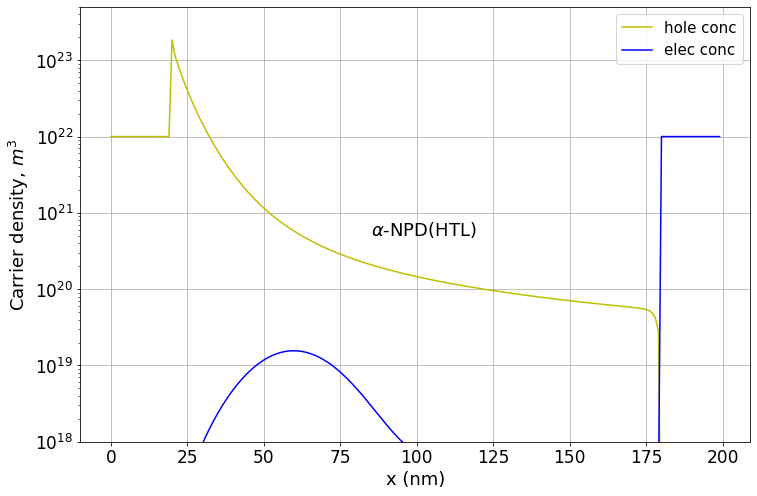

In [487]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(0,200,1), p_fin[1]/a**3, c = 'y', label = "hole conc")
plt.plot(np.arange(0,200,1), n_fin[1]/a**3, c = 'b', label = "elec conc")
plt.ylim(1.e18, 5.e23)
plt.yscale('log')
plt.xlabel("x (nm)");plt.ylabel("Carrier density, "+r'$m^3$')
plt.text(85, 5.e20, r"$\alpha$"+"-NPD(HTL)", fontsize = 18)
#plt.text(148, 5.e-9, r"$Alq_3$"+"\n(ETL)", fontsize = 18)
plt.rc('ytick', labelsize=15);plt.rc('xtick', labelsize=15)
plt.rc('axes', labelsize=15)
plt.rc('legend', fontsize=15)
plt.legend()
plt.grid()
#plt.savefig("./210716_ME_figure/1D_concentration.png", dpi = 300)

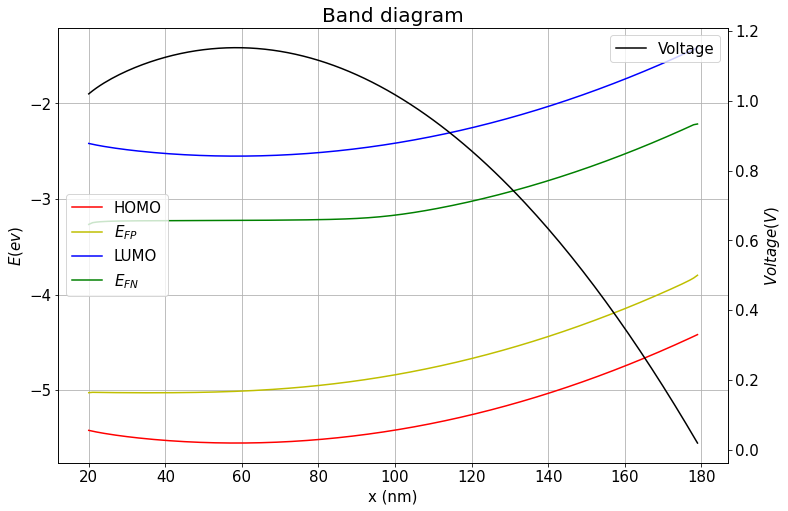

In [488]:
X_ = np.arange(0,200,1)
fig, ax1 = plt.subplots(figsize = [12,8])

ax2 = ax1.twinx()

ax1.plot(X_[20:180], H_NPD[20:180], c = 'r', label="HOMO")
ax1.plot(X_[20:180], E_FP[20:180], c = 'y', label=r"$E_{FP}$")
ax1.plot(X_[20:180], L_NPD[20:180], c = 'b', label="LUMO")
ax1.plot(X_[20:180], E_FN[20:180], c = 'g', label=r"$E_{FN}$")
ax2.plot(X_[20:180], V[20:180], c = 'k', label="Voltage")
ax1.set_title("Band diagram", fontsize = 20)
ax1.set_xlabel("x (nm)", fontsize = 15)
ax1.set_ylabel(r"$E(ev)$", fontsize = 15)
ax2.set_ylabel(r"$Voltage(V)$", fontsize = 15)
ax1.grid()
ax1.legend(loc = 6)
ax2.legend()

In [489]:
print(prob_intg(EF_LiFAl, LUMO_NPD, SigL_NPD, field[179], "Elec")*beta_cathode)
print(prob_intg(E_FP[30], E_trap[30], Sig_trap, 1, "Hole"))
print(E_FP[30], E_trap[30])

1.8258065184234257e-10
0.9999999999635137
-5.0263554583386805 -4.2125


In [495]:
# P current + N current in Master equation
curr = []
for volt in V_fin.keys():
    curr_temp = (jn_fin[volt]+jp_fin[volt])*q/a**2
    curr.append(np.mean(curr_temp[21:178]))

In [496]:
curr

[-0.005011344408025501,
 -0.0005754635358237297,
 0.026271583994284017,
 6.2448947075515635]

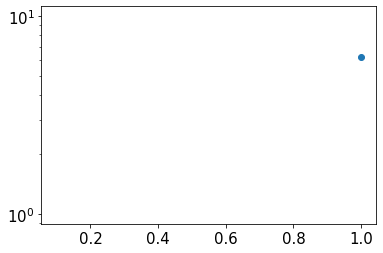

In [491]:
plt.scatter(V_fin.keys(), curr)
plt.yscale("log")

In [492]:
# Former 1D EGDM+Gummel model
V_gummel = [0.05, 0.1, 0.15, 0.2, 0.5, 1, 2, 3, 4, 7, 10, 15]
J_gummel = [1.998667086583649, 6.321145127601985, 12.95248440652368, 21.894895681856504, 124.01269860848572, 483.3573089510596, 1959.0903826577753, 4541.409352311683, 8364.619749869353, 29075.695526348638, 69137.16928757439, 211099.94539222124]

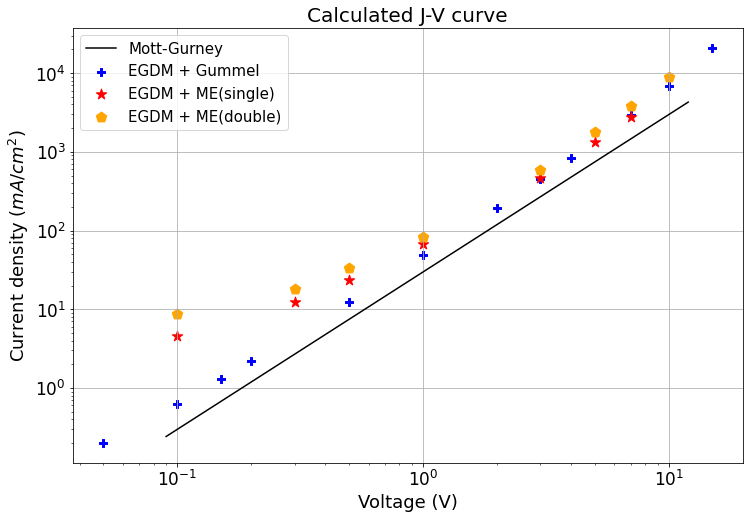

In [523]:
# Calculate Mott-gurney current(SCLC)
def MottGurney(volt):
    return 9/8*e0*er*mp0[100]*volt**2/(160e-9)**3
V_MG = np.arange(0.09, 12, 0.01)

plt.figure(figsize=(12,8))
plt.plot(V_MG, np.array(MottGurney(V_MG))/10, c = 'k', label = "Mott-Gurney")
plt.scatter(V_gummel, np.array(J_gummel)/10, c = 'b', s = 50, \
            marker = 'P', label = "EGDM + Gummel")
plt.scatter(Voltage_single, np.array(trap_zero)/10, c = 'r', s = 120, \
            marker = '*', label = "EGDM + ME(single)")
plt.scatter(Voltage_total, np.array(current_total)/10, c = 'orange', s = 120, \
            marker = 'p', label = "EGDM + ME(double)")
plt.title("Calculated J-V curve", fontsize = 20)

plt.xlabel("Voltage (V)");plt.ylabel("Current density "+r"$(mA/cm^2)$")
plt.yscale('log')
plt.xscale('log')
plt.rc('ytick', labelsize=17);plt.rc('xtick', labelsize=17)
plt.rc('axes', labelsize=18)
plt.rc('legend', fontsize=15)

plt.grid()
plt.legend()
#plt.savefig("./210716_ME_figure/1D_comparison_semilog.png", dpi = 300)

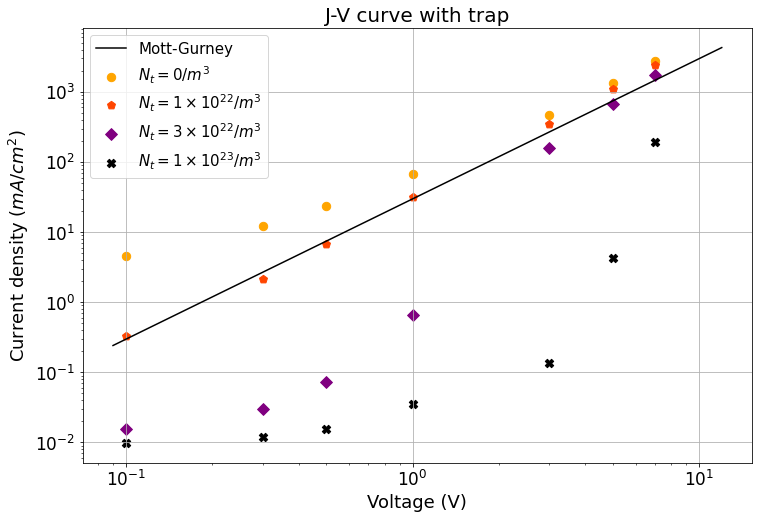

In [518]:
plt.figure(figsize=(12,8))
plt.plot(V_MG, np.array(MottGurney(V_MG))/10, c = 'k', label = "Mott-Gurney")

plt.scatter(Voltage_single, np.array(trap_zero)/10, c = 'orange', s = 70, marker = 'o', \
            label = r"$N_{t}= 0/m^{3}$")
plt.scatter(Voltage_single, np.array(trap_1em5)/10, c = 'orangered', s = 70, marker = 'p', \
            label = r"$N_{t}= 1\times 10^{22}/m^{3}$")
plt.scatter(Voltage_single, np.array(trap_3em5)/10, c = 'purple', s = 70, marker = 'D', \
            label = r"$N_{t}= 3\times 10^{22}/m^{3}$")
plt.scatter(Voltage_single, np.array(trap_1em4)/10, c = 'k', s = 70, marker = 'X', \
            label = r"$N_{t}= 1\times 10^{23}/m^{3}$")
plt.title("J-V curve with trap", fontsize = 20)

plt.xlabel("Voltage (V)");plt.ylabel("Current density "+r"$(mA/cm^2)$")
plt.yscale('log')
plt.xscale('log')
plt.rc('ytick', labelsize=17);plt.rc('xtick', labelsize=17)
plt.rc('axes', labelsize=18)
plt.rc('legend', fontsize=15)

plt.grid()
plt.legend()

In [521]:
No_trap = [31.92202925823829, 45.28252581824945,78.76938189588647,232.30266575254007,664.2461537564659,2199.0739762958387,
           4658.643028665173, 8262.682438182266,19729.00801392797,37583.36886590231,63517.051697696224,180440.46907485597]

Voltage_single = [0.1, 0.3, 0.5, 1, 3, 5, 7]
trap_1em4 = [0.0983853137549003, 0.11972834508346797, 0.15552593188520605, 0.3568327680724739,
            1.352557878962528, 42.734920492282505, 1956.949421975623]
trap_3em5 = [0.155011344408025501,0.295754635358237297,0.726271583994284017,6.5448947075515635,
            1567.9049773682698, 6688.211164235187, 17318.438299413265]
trap_1em5 = [3.2927103169182277,21.341768549348735,67.0127501441525,318.3262381810907,
            3491.4664087408923,10912.48856192943,24095.570417920986]
trap_zero = [45.149061667998154,121.91437605229493,232.45247433994152,664.2085775440413,
            4658.113863737348,13281.468745156899,27763.789563129983]

Voltage_total = [0.1, 0.3, 0.5, 1, 3, 5, 7, 10]
current_total = [87.48660685728409, 180.99097213034202, 329.77167089732032, 837.4645409093102,
                 5934.680770350321, 17626.43911451552, 37962.273839128306, 89827.02282705948]

In [499]:
curr

[-0.005011344408025501,
 -0.0005754635358237297,
 0.026271583994284017,
 6.2448947075515635]